### Makemore lesson 3

In [2]:
##Create train, dev/val,test
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [3]:

words = open('names.txt', 'r').read().splitlines()
random.seed(42)
random.shuffle(words)

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

#Building the dataset - very similar to the trigram construction but dynamic
def prepare_data(data, block_size):

    block_size = block_size #alternative for context length

    X, Y = [], []

    for w in data:

        #print(w, '--- word of interest')
        context = [0] * block_size #How many characters to consider from the left to the right
        for ch in w + '.': #adding end word
            
            ix = stoi[ch]

            X.append(context)
            Y.append(ix)

            #print(''.join(itos[i] for i in context), '--->', itos[ix])

            context = context[1:] + [ix] #context is redefined as a new list and we move the window to the right


    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

train_limit = int(0.8*len(words))
dev_limit = int(0.9*len(words))
block_size = 3

Xtr, Ytr = prepare_data(words[:train_limit], block_size = block_size)
Xdev, Ydev = prepare_data(words[train_limit:dev_limit], block_size = block_size)
Xtest, Ytest = prepare_data(words[dev_limit:], block_size = block_size)

In [4]:
Xtr.shape, Xdev.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]))

In [ ]:
vocab_size = len(stoi)
embedding_dim = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, embedding_dim), generator = g)
#W1 = torch.randn((embedding_dim * block_size, n_hidden), generator = g) *0.1  #making sure we don't have vanishing gradients
W1 = torch.randn((embedding_dim * block_size, n_hidden), generator = g) * (5/3) / (embedding_dim * block_size)
b1 = torch.randn(n_hidden, generator = g) *0.01 #making sure we don't have vanishing gradients with tanh
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01 #making sure don't hve exploding initialization loss
b2 = torch.randn(vocab_size, generator = g) * 0 #making sure we don't have exploding initialization

bngain = torch.ones((1, n_hidden)) #must be trained with backpropagation, include in parameters list
bnbias = torch.zeros((1, n_hidden)) #must be trained with backpropagation, include in parameters list
bnmean_running = torch.ones((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

#Batch normalization parameters
parameters = [C,W1, b1, W2, b2, bngain, bnbias]

param_sum = 0
for p in parameters:
    p.requires_grad = True
    param_sum += p.nelement()

print(f"Number of parameters: {param_sum}")



Number of parameters: 12297


#kaiming initialization


In [ ]:
max_iterations = 200000
batch_size = 32
lossi = []
for it in range(max_iterations):

    #Mini batches
    batch = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)


    #Forward pass
    embedding = C[Xtr[batch]]
    embdcat = embedding.view(embedding.shape[0],-1) #concatenate the vectores
    hpreact = embdcat @ W1 + b1#hidden layer pre-activation, we want this to be roughly gaussian 
    


    #batch normalization layer
    # __________________________________

    bnmeani = hpreact.mean(0, keepdim = True)
    bnstdi = hpreact.std(0, keepdim = True)
    hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 + bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 + bnstdi


    ##Non-linearity
    tanh = torch.tanh(hpreact)#hidden layer
    logits = tanh@W2 + b2 #output layer
    loss = F.cross_entropy(logits, Ytr[batch])#loss function


    #We need to reset the gradients before we run backward so that we don't compile grads
    for p in parameters:
        p.grad = None

    lossi.append(loss.log10().item())
    #steps.append(it)

    #backward pass
    loss.backward()
    lr = 0.1 if it < 100000 else 0.01

    #Now update the parameters
    for p in parameters:
        p.data += -lr * p.grad

    if it % 10000 == 0:
        print(f'{it:7d}/{max_iterations:7d}: {loss.item():.4f}')


    
    break
    


print(f"Training Loss: {loss.item()}")

    




      0/ 200000: 3.3013
Training Loss: 3.301253318786621


### Exploring the tanh issue
    - using tanh forces embedding@W1 + b1 values to be pushed from -1 to 1. 
    - However, many of these calculated values are rather extreme. See the distribution of embdcat @ W1 + b1 values. This correlates to a bifurcated distribution of extreme values to -1 and 1. These slow down gradient learning and lead to sort permanently weighted neurons that are hard to tinker with. They sort of get bogged down because the closer values are to -1 or 1 the closer the multiple of tanh derivative is during backpropagation

    - if input is close to zero there is no real change to gradient as well.  (t= 0), out.grad is just passed through (sort inactive)

    def _backward():
        self.grad += (1 - t**2) * out.grad

    If t is ~1 or ~1, (1-t**2) is very close to zero and we have almost no gradient changes. 

    Vanishing gradient problem!! This causes an issue where the neuron does not work
    
    
    
    

##### Histogram plot of the first layer
    - ideally we want to see a smaller value distribution on the x-axis
    

(array([1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        3.000e+00, 7.000e+00, 1.100e+01, 1.300e+01, 1.200e+01, 2.400e+01,
        2.200e+01, 3.200e+01, 3.800e+01, 3.900e+01, 6.800e+01, 8.100e+01,
        1.020e+02, 1.100e+02, 1.450e+02, 1.730e+02, 1.820e+02, 2.290e+02,
        2.616e+03, 1.080e+03, 2.600e+02, 2.100e+02, 1.640e+02, 1.330e+02,
        1.270e+02, 1.010e+02, 7.900e+01, 6.700e+01, 6.100e+01, 4.400e+01,
        3.100e+01, 3.100e+01, 3.000e+01, 1.800e+01, 1.200e+01, 1.100e+01,
        5.000e+00, 9.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00]),
 array([-10.4807539 , -10.05948309,  -9.63821228,  -9.21694147,
         -8.79567066,  -8.37439985,  -7.95312904,  -7.53185823,
         -7.11058743,  -6.68931662,  -6.26804581,  -5.846775  ,
         -5.42550419,  -5.00423338,  -4.58296257,  -4.16169176,
         -3.74042095,  -3.31915014,  -2.89787933,  -2.47660852,
         -2.05533772,  -1.63406691,  -1.2127961 ,  -0.79

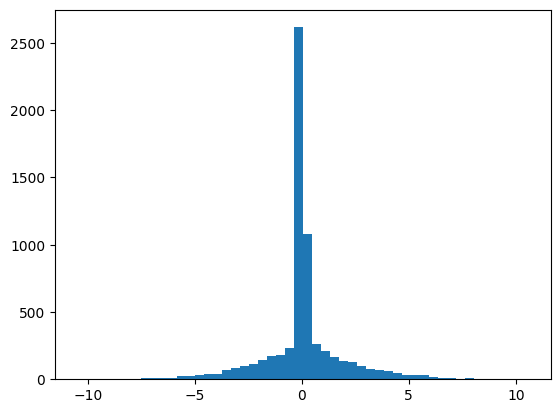

In [14]:
plt.hist((hpreact).view(-1).tolist(), bins = 50)

##### Histogram plot of activation function
- Ideally want to see a more normal distribution of values as output for the tanh activation layer

view test true


(array([600., 143.,  87.,  56.,  60.,  31.,  37.,  35.,  32.,  40.,  44.,
         31.,  15.,  27.,  22.,  34.,  36.,  24.,  47.,  92.,  88., 150.,
        241., 452., 654., 706., 401., 261., 151., 102.,  84.,  40.,  58.,
         46.,  41.,  28.,  34.,  36.,  40.,  26.,  40.,  43.,  46.,  61.,
         48.,  54.,  70.,  78., 135., 693.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

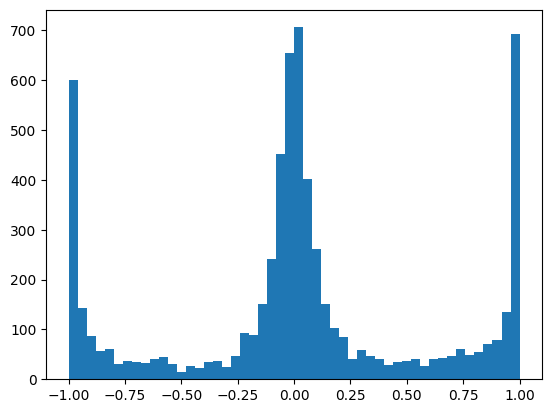

In [15]:
tanh.shape
if tanh.view(tanh.shape[0] * tanh.shape[1]).shape == tanh.view(-1).shape:
    print("view test true")

list(tanh.view(-1))
plt.hist(tanh.view(-1).tolist(),  bins=50)


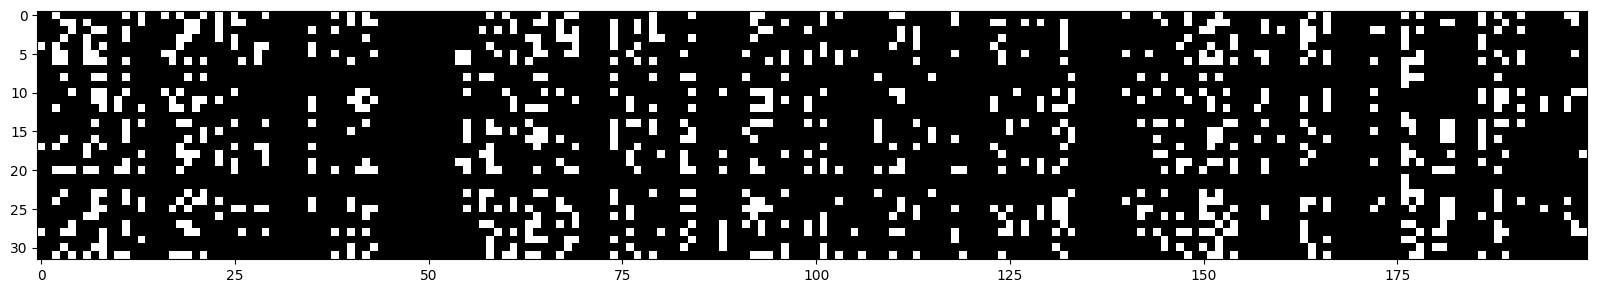

In [16]:
plt.figure(figsize = (20,10))
plt.imshow(tanh.abs() > 0.99, cmap = 'gray', interpolation = 'nearest')

#### Plot of lossi vs step, we want to the hockey stick drop in loss associated with randomly generated larger weights

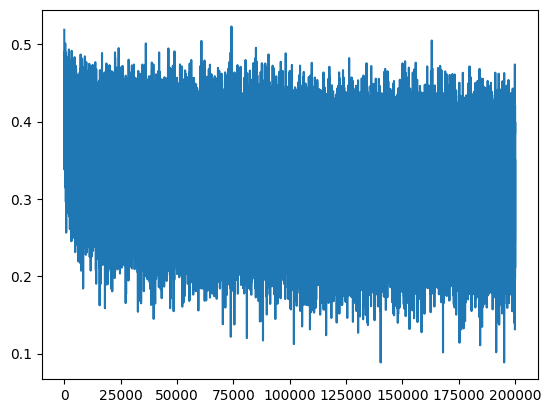

In [17]:
plt.plot(lossi)


#### End of training batch normalization
- should match bnmean_running
- should match bnstd_running

In [ ]:
#calibrate the batch norm at the end of training
with torch.no_grad():

    #pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0],  -1)
    hpreact = embcat @W1 + b1

    #Measure the mean/std over the entire training set
    bmean = hpreact.mean(0, keepdim = True)
    bstd = hpreact.std(0, keepdim = True)

In [ ]:
@torch.no_grad() #-> this decorator disables the gradient tracking
def split_loss(split):
    x,y = {'train': (Xtr, Ytr),
            'dev': (Xdev, Ydev),
            'test': (Xtest, Ytest)}[split]

    print(x.shape, y.shape)
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat@W1 + b1
    
    #Batch normalization without whole training set normalization for small samples
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True))/hpreact.std(0, keepdim = True) + bnbias

    hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias

    hpreact_dprec = bngain * (hpreact - bmean)/bstd + bnbias

    h = torch.tanh(hpreact)
    logits = h @W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss('train')
split_loss("dev")
split_loss("test")
    

torch.Size([182625, 3]) torch.Size([182625])
train 2.0847249031066895
torch.Size([22655, 3]) torch.Size([22655])
dev 2.125988721847534
torch.Size([22866, 3]) torch.Size([22866])
test 2.1233270168304443


In [19]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(40):
    out = []

    context = [0] * block_size 

    while True:
        emb = C[torch.tensor([context])] #-> turns the generated context into an embedding from our adjusted look up table post grad owkr
        embdcat = emb.view(1, -1)
        h = torch.tanh(embdcat@W1 + b1)

        logits = h@W2 + b2

        probs = F.softmax(logits, dim =1)

        #sample from the distribution
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()

        context = context[1:] + [ix]

        out.append(ix)

        if ix == 0:
            break


    print("".join(itos[i] for i in out))


mora.
mayah.
see.
med.
rylle.
emmani.
jerlee.
adelyn.
elin.
shi.
jen.
eden.
estanaraelyn.
malaia.
noshubvigahimies.
kindreelynn.
novana.
uberteder.
yarue.
els.
kayshayvondrihia.
salynn.
julian.
leon.
ell.
revis.
jaosi.
prad.
jaquese.
ban.
peila.
amuelyn.
huner.
jia.
siri.
evon.
walla.
ortara.
zim.
desira.


### Pytorchifying thing

In [24]:
# SUMMARY + PYTORCHIFYING -----------

In [ ]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
# layers = [
#   Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
# ]
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  #layers[-1].gamma *= 0.1 #When using batch norm
  layers[-1].weight *= 0.1 #artificially makes outer layer less confident. 
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 #1.0 #5/3 ###gain section

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [64]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 21.97%
layer 3 (      Tanh): mean -0.01, std 0.72, saturated: 11.00%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 13.00%
layer 7 (      Tanh): mean -0.05, std 0.73, saturated: 13.34%
layer 9 (      Tanh): mean +0.00, std 0.72, saturated: 10.53%


Text(0.5, 1.0, 'activation distribution')

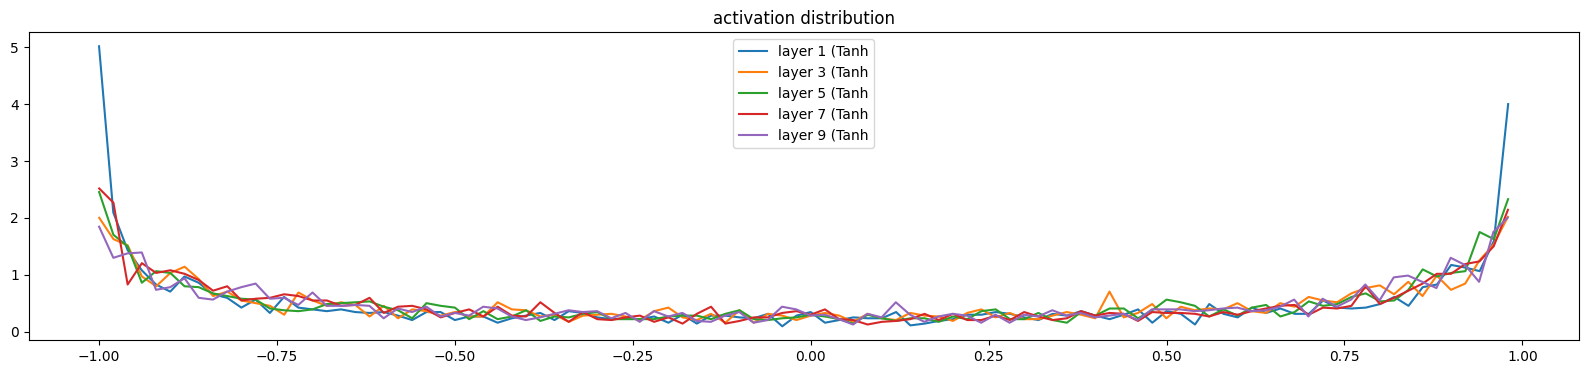

In [65]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000024, std 3.353992e-03
layer 3 (      Tanh): mean +0.000012, std 3.157344e-03
layer 5 (      Tanh): mean -0.000004, std 2.925863e-03
layer 7 (      Tanh): mean +0.000036, std 2.715700e-03
layer 9 (      Tanh): mean +0.000020, std 2.308167e-03


Text(0.5, 1.0, 'gradient distribution')

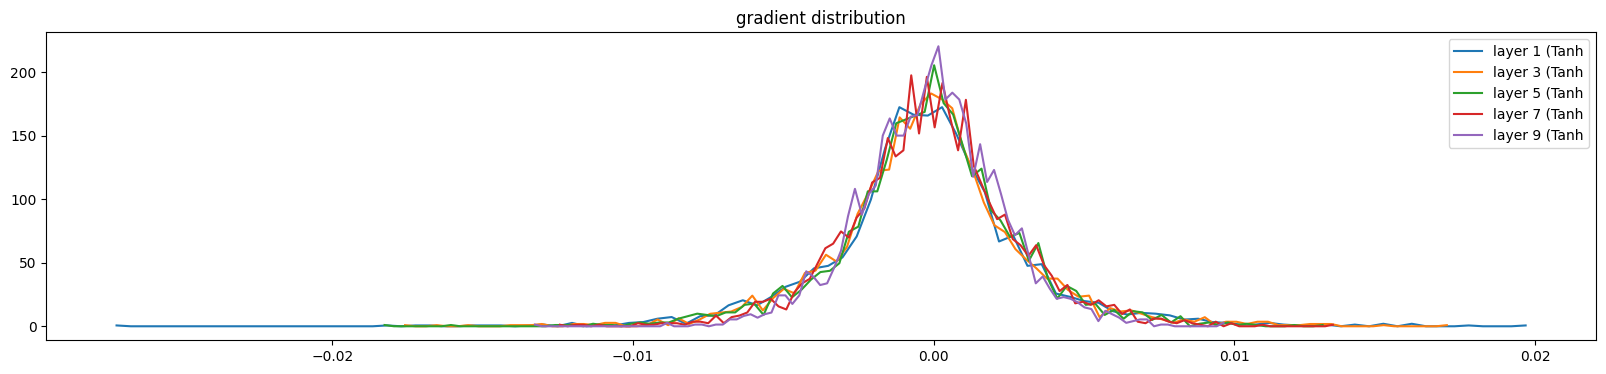

In [66]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000980 | std 1.189171e-02 | grad:data ratio 1.189149e-02
weight  (30, 100) | mean +0.000118 | std 1.005291e-02 | grad:data ratio 3.214556e-02
weight (100, 100) | mean +0.000033 | std 7.821212e-03 | grad:data ratio 4.653362e-02
weight (100, 100) | mean -0.000107 | std 6.655620e-03 | grad:data ratio 3.925851e-02
weight (100, 100) | mean -0.000017 | std 6.086041e-03 | grad:data ratio 3.605768e-02
weight (100, 100) | mean -0.000077 | std 5.075620e-03 | grad:data ratio 3.015269e-02
weight  (100, 27) | mean +0.000000 | std 2.056585e-02 | grad:data ratio 2.909911e-01


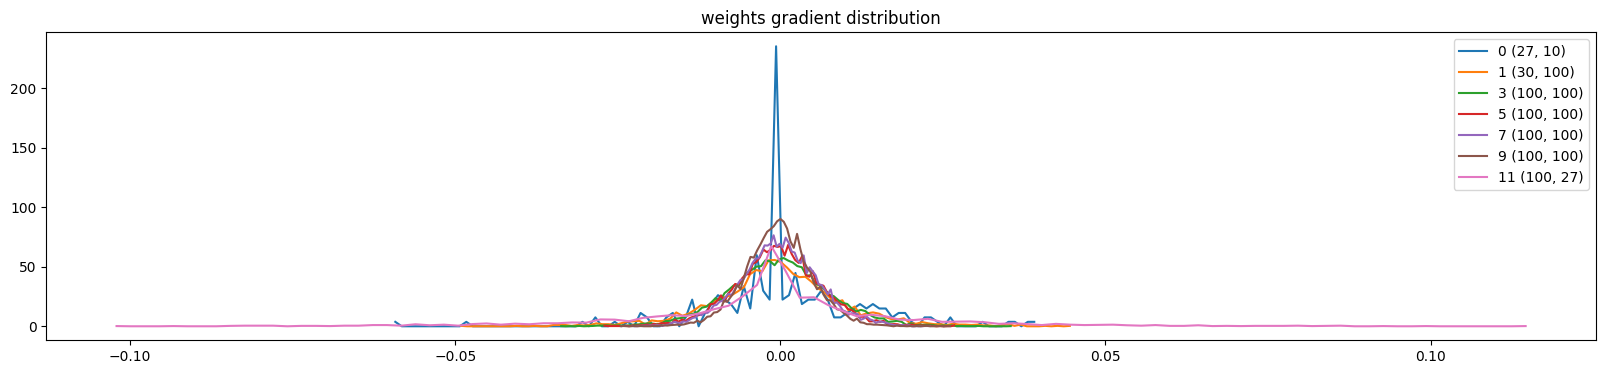

In [67]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  
  if p.ndim == 2: #only looking at weights here based on ndim filter here.
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

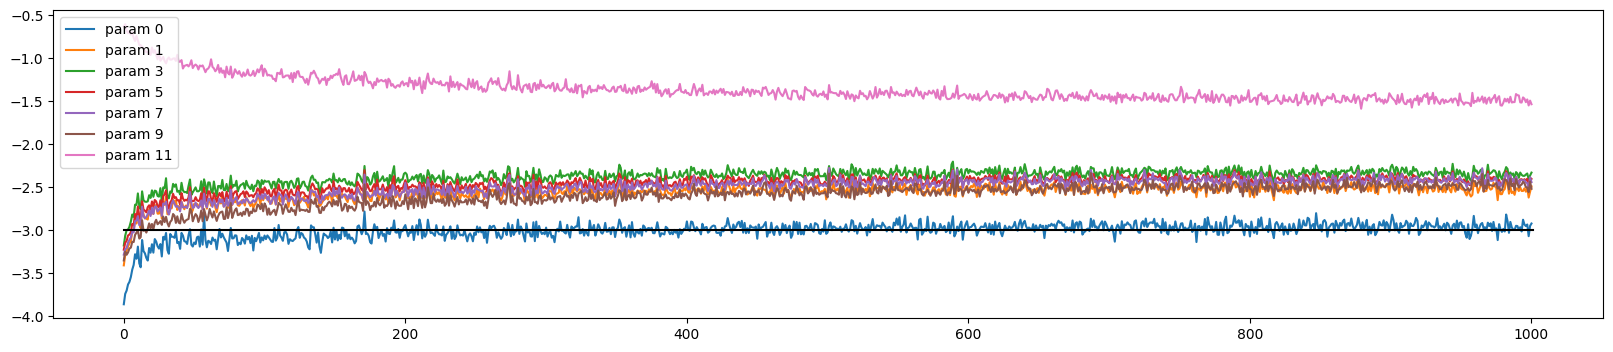

In [31]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xtest, Ytest),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
      x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word